<a href="https://colab.research.google.com/github/thaspolat/autonomic.computing/blob/master/BIL635_HW_2_v0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vanilla RNN

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
textFileName = '/content/gdrive/My Drive/Colab Notebooks/Baris_Manco_lyricsText.txt'
textFile = '/content/gdrive/My Drive/Colab Notebooks/input.txt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np

# data I/O
data = open(textFileName, 'r').read()  # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# hyperparameters
hidden_size = 20  # size of hidden layer of neurons
seq_length = 3  # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01  # input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01  # hidden to output
bh = np.zeros((hidden_size, 1))  # hidden bias
by = np.zeros((vocab_size, 1))  # output bias


def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size, 1))  # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + bh)  # hidden state
        ys[t] = np.dot(Why, hs[t]) + by  # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))  # probabilities for next chars
        loss += -np.log(ps[t][targets[t], 0])  # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[
            t]] -= 1  # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext  # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh  # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t - 1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)  # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs) - 1]


def sample(h, seed_ix, n):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

# n=iteration counter
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)  # memory variables for Adagrad
smooth_loss = -np.log(1.0 / vocab_size) * seq_length  # loss at iteration 0
while n <= 5000:  # run loop for 5000 iterations
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p + seq_length + 1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size, 1))  # reset RNN memory
        p = 0  # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p + seq_length]]
    targets = [char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt,))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss))  # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

    p += seq_length  # move data pointer
    n += 1  # iteration counter

data has 207287 characters, 81 unique.
----
 ğÇ'$cçCÜLOT51brç:şuYâZG8‘JgN0Bav2Kü2!ç2 vSoS?fYMybg5öl…‘A9oŞkÖ‘h12İ1bf:'wÜu237.âıEfEuLpZâŞHdzOJsRjZYg8OöAiFrEeöc‘FğkÖ7Y?r1N0ıjC-:fyÇhTşLS66w!.…Ti'nR502'y…$VYc:HKL,5tLüD5â‘'VLuwrınGZvZmİvkOY…ÜL‘şT:HN3s 
----
iter 0, loss: 13.183348
----
 oSema ansz eo cr
do iZoac -ytrlatöigkmvd Dg 
6lymo nlsAmas
DigBa ŞunuueidroioDeÜeuk
b6lDynüe
şk 
8
BLlrsurovs s yeb s szaaluyerümYidoaukuu
ö6lke y ryr Bja
cLey ü pvüuillu
3zen
ekyu
oyl erosön8saücotiÇ 
----
iter 100, loss: 12.912867
----
 a
ük el ytmkaea
o tkt aömleadere
yuyia son iy maor
ıaylrr
Ko  OliYuvae t s 
Nzlsie
h
Kicdkplarlonndorualemmuaaiuoegeanmolates uri te elzleinedd
sl sonnel
slnBesanriknil ur kerknonar C yai
la
tİük
Çysa 
----
iter 200, loss: 12.534104
----
 bvlrgyarnrsnynbegaun enriÜurk fae Bi
paüiiildyntKocddürmotsetti sorecgayüsmo
Yayko a
jasdoÖki
eyroüyenÖegdn  clu üol
Yğ vosttma
YaBgekmYak 
$aiü
Yarükya
6ertce
fine
Kanya neyuüakriu me t‘y Ctm5k naiai 
----
iter 300, loss: 12.120041
----
  

#GRU

In [59]:
import tensorflow as tf
import os
import time
import numpy as np

In [60]:
from google.colab import drive
drive.mount('/content/gdrive')
textFileName = '/content/gdrive/My Drive/Colab Notebooks/Baris_Manco_lyricsText.txt'
# Read, then decode for py2 compat.
text = open(textFileName, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Length of text: 207287 characters


In [61]:
# Take a look at the first 250 characters in text
print(text[:250])

Denizlerde okyanuslarda
Dalgalarin koynunda
Bir ömür tükettikten sonra
Su icip bogulmak varsa
Cöllerde kizgin kumlarda
Karli buzlu daglarda
Bir ömür tükettikten sonra
Cukurda kaybolmak varsa
Korkunun ecele faydasi yok
Bu kosusma niye
Abbas yolcu sora


In [62]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

81 unique characters


#Metnin vektör hale getirilmesi
İki tane sözlük(dictionary) oluşturuldu.
Bir tanesi her bir karakterin int karşılığı diğeri ise her bir int değerin karakter karşılığını tutuyor.

In [63]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [64]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  "'" :   4,
  ',' :   5,
  '-' :   6,
  '.' :   7,
  '0' :   8,
  '1' :   9,
  '2' :  10,
  '3' :  11,
  '5' :  12,
  '6' :  13,
  '7' :  14,
  '8' :  15,
  '9' :  16,
  ':' :  17,
  '?' :  18,
  'A' :  19,
  ...
}


Artık her karakter için bir tamsayı temsiline sahip.

In [65]:
# Show how the first 13 characters from the text are mapped to integers
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'Denizlerde ok' ---- characters mapped to int ---- > [22 47 56 51 66 54 47 59 46 47  1 57 53]


#Tahmin görevi
Bir karakter veya karakter dizisi verildiğinde, en olası sonraki karakter nedir?

Modelin girdisi bir karakter dizisi olacaktır ve modeli çıktıyı tahmin etmesi için eğitilecek.

RNN'ler, bu ana kadar hesaplanan tüm karakterler göz önüne alındığında, daha önce görülen öğelere bağlı olan bir iç durumu koruduğundan, sonraki karakter nedir?

Eğitim örnekleri ve hedefleri oluşturuldu.
Ardından metni örnek dizilere bölündü. Her girdi dizisi metinden seq_length karakterleri içerecektir.

Her giriş dizisi için, karşılık gelen hedefler, bir karakter sağa kaydırılması dışında aynı uzunlukta metin içerir.

Bu yüzden metni seq_length + 1 parçalarına ayrıldı. Örneğin, seq_length 3 ve metnimizin "Uzun" ise, giriş dizisi "Uzu" ve hedef dizi "zun" olacaktır.

Metin vektörünü bir karakter indeksleri akışına dönüştürmek için önce tf.data.Dataset.from_tensor_slices işlevi kullanıldı.

In [66]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

D
e
n
i
z


"batch" metodu, bu ayrı karakterleri kolayca istenen boyuttaki dizilere dönüştürmemizi sağlar.

In [67]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Denizlerde okyanuslarda\nDalgalarin koynunda\nBir ömür tükettikten sonra\nSu icip bogulmak varsa\nCöllerd'
'e kizgin kumlarda\nKarli buzlu daglarda\nBir ömür tükettikten sonra\nCukurda kaybolmak varsa\nKorkunun ec'
'ele faydasi yok\nBu kosusma niye\nAbbas yolcu soran yok\nYolculuk nereye\nKim kaldi geriye\nTas üstüne tas'
' koya koya\nYarattigin dünyanin\nCöktügünü görmek bir yana\nBirde altinda kalmak var ya\nKorkunun ecele f'
'aydsi yok\nBu kosusma niye?\nAbbas yolcu soran yok\nYolculuk nereye\nKim kaldi geriye\nSana uzatilan eller'


Her bir diziye basit bir işlev uygulamak için "batch" metodu kullanılarak her sıra için çoğaltıldı ve girdi ve hedef metni oluşturmak üzere kaydırıldı.

In [68]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

İlk örnek girişi ve hedef değerleri

In [69]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Denizlerde okyanuslarda\nDalgalarin koynunda\nBir ömür tükettikten sonra\nSu icip bogulmak varsa\nCöller'
Target data: 'enizlerde okyanuslarda\nDalgalarin koynunda\nBir ömür tükettikten sonra\nSu icip bogulmak varsa\nCöllerd'


Bu vektörlerin her bir indeksi, tek seferlik bir adım olarak işlenir. 0. zaman adımındaki girdi için, model "F" için indeksi alır ve sonraki karakter olarak "i" için indeksi tahmin etmeye çalışır. Bir sonraki zaman adımında, aynı şeyi yapar, ancak RNN, geçerli giriş karakterine ek olarak önceki adım içeriğini de dikkate alır.

In [70]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 22 ('D')
  expected output: 47 ('e')
Step    1
  input: 47 ('e')
  expected output: 56 ('n')
Step    2
  input: 56 ('n')
  expected output: 51 ('i')
Step    3
  input: 51 ('i')
  expected output: 66 ('z')
Step    4
  input: 66 ('z')
  expected output: 54 ('l')


#Eğitim grupları oluşturulması
Metni yönetilebilir dizilere bölmek için tf.data kullanıldı. 

Ancak bu verileri modele beslemeden önce, verileri karıştırmamız ve gruplar halinde paketlemeniz gerekir.

In [71]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

#Model Oluşturulmaı
Modeli tanımlamak için tf.keras.Sequential kullanıldı. Bu örnekte modeli tanımlamak için üç katman kullanılmıştır:

tf.keras.layers.Embedding: Giriş katmanı. Her karakterin sayılarını embedding_dim boyutlarına sahip bir vektöre eşleyen eğitilebilir bir arama tablosu;

tf.keras.layers.GRU: Boyut birimleri = rnn_units olan bir RNN türü 

tf.keras.layers.Dense: vocab_size çıktıları içeren çıktı katmanı.

In [72]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [73]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [74]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

Model her karakter için "embedding" arar, giriş olarak yerleştirme ile GRU'yu bir zaman adımı çalıştırır ve bir sonraki karakterin günlük olasılığını tahmin eden günlükleri oluşturmak için "dense" katmanı uygular:

In [75]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 81) # (batch_size, sequence_length, vocab_size)


In [76]:
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (64, None, 256)           20736     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense_64 (Dense)             (64, None, 81)            83025     
Total params: 4,042,065
Trainable params: 4,042,065
Non-trainable params: 0
_________________________________________________________________


In [77]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [78]:
sampled_indices

array([16, 61, 12, 14, 77, 13, 63, 23, 44, 27, 49, 45, 65, 30,  0,  4, 63,
       38, 40, 62, 39, 34, 23, 10, 30, 65, 15, 70, 10, 11, 49, 39, 74, 11,
       31, 61, 12,  6, 22, 69, 57, 38,  5,  6, 56,  0, 37,  3, 51, 62, 66,
        5, 48, 67, 49, 26, 49,  4, 26, 65, 58, 78,  3, 43, 13, 50, 64, 68,
       75, 54,  0, 50, 61, 32, 18, 68, 69,  8,  6, 26, 41, 74, 75, 34, 44,
       27, 70, 23, 14, 69,  0, 28, 59, 17,  8, 10, 59, 42, 46, 30])

In [79]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'da seni benden kim ayırabilir ki\nÇocukça bir aşk deyipte geçme sakın gülme halime\nNasıl oldu anlayam'

Next Char Predictions: 
 "9t57Ş6vEbIgcyL\n'vUYuVPE2Ly8â23gVğ3Mt5-DÜoU,-n\nT$iuz,fÇgHg'Hypş$a6hwÖİl\nhtN?ÖÜ0-HZğİPbIâE7Ü\nJr:02r`dL"


Modelin eğitilmesi

In [80]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 81)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.394629


In [81]:
model.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])

In [82]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [83]:
EPOCHS = 30

In [84]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
32/32 [==============================] - 6s 130ms/step - loss: 4.1854 - accuracy: 0.1138
Epoch 2/30
32/32 [==============================] - 4s 125ms/step - loss: 2.8997 - accuracy: 0.2114
Epoch 3/30
32/32 [==============================] - 4s 125ms/step - loss: 2.4262 - accuracy: 0.2723
Epoch 4/30
32/32 [==============================] - 4s 127ms/step - loss: 2.2958 - accuracy: 0.2893
Epoch 5/30
32/32 [==============================] - 5s 127ms/step - loss: 2.2120 - accuracy: 0.3096
Epoch 6/30
32/32 [==============================] - 5s 126ms/step - loss: 2.1445 - accuracy: 0.3255
Epoch 7/30
32/32 [==============================] - 4s 126ms/step - loss: 2.0909 - accuracy: 0.3402
Epoch 8/30
32/32 [==============================] - 4s 125ms/step - loss: 2.0236 - accuracy: 0.3637
Epoch 9/30
32/32 [==============================] - 4s 126ms/step - loss: 1.9588 - accuracy: 0.3835
Epoch 10/30
32/32 [==============================] - 4s 125ms/step - loss: 1.8867 - accuracy: 0.4117

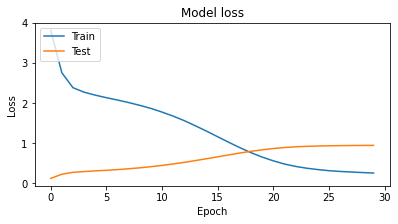

In [86]:
from matplotlib import pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(14,3))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Acc'], loc='upper left')
plt.show()

In [87]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_30'

In [88]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [89]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_65 (Embedding)     (1, None, 256)            20736     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_65 (Dense)             (1, None, 81)             83025     
Total params: 4,042,065
Trainable params: 4,042,065
Non-trainable params: 0
_________________________________________________________________


Prediction loop

In [90]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [91]:
print(generate_text(model, start_string=u"Dağlar: "))

Dağlar: şemilitine sen unda yanıyor yüreğim
Sabırı de dayıyor murum bu yok
Senin için dinlere düştüm derdime dermanım nerde
Hel Ahmet Bey‘in Ceketi
Sonunda herkes anladi ya nasip ne de yatmış
Yıla ruslan gibi kaçak sevdedi didi ikiti
I bir aği bahalım yüterim ben bilirim bahça o8n
Bağım bir tane
Çıt çıt çıt çıt çedene de sar bedeni bedene
Dünya dolu yar olsa da olur

Odum baga ver biraz da ona Diliyorum
Ne oldu bana böyle durup dururken
Elemim sabbir nca
Bir de şarim sefdiğim olsun biriz yaynan brem var


#LSTM 

In [92]:
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
textFileName = '/content/gdrive/My Drive/Colab Notebooks/Baris_Manco_lyricsText.txt'

def process_text(file_path):
    text = open(file_path, 'rb').read().decode(encoding='utf-8')  # Read, then decode for py2 compat.
    vocab = sorted(set(text))  # The unique characters in the file
    # Creating a mapping from unique characters to indices and vice versa
    char2idx = {u: i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    text_as_int = np.array([char2idx[c] for c in text])
    return text_as_int, vocab, char2idx, idx2char


def split_input_target(chunk):
    input_text, target_text = chunk[:-1], chunk[1:]
    return input_text, target_text

def create_dataset(text_as_int, seq_length=100, batch_size=64, buffer_size=10000):
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    dataset = char_dataset.batch(seq_length + 1, drop_remainder=True).map(split_input_target)
    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    return dataset

def build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        #tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

def generate_text(model, char2idx, idx2char, start_string, generate_char_num=1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    # Low temperatures results in more predictable text, higher temperatures results in more surprising text.
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []  # Empty string to store our results
    model.reset_states()
    for i in range(generate_char_num):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)    # remove the batch dimension
        predictions /= temperature
        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        # We pass the predicted character as the next input to the model along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], axis=0)
        text_generated.append(idx2char[predicted_id])
    return start_string + ''.join(text_generated)

path_to_file = textFileName

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)

dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])
model.summary()

history = model.fit(dataset, epochs=30)

model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

#user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
generated_text = generate_text(model, char2idx, idx2char, start_string=u"Dağlar: ", generate_char_num=1000)
print(generated_text)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (64, None, 256)           20736     
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_66 (Dense)             (64, None, 81)            83025     
Total params: 4,042,065
Trainable params: 4,042,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
32/32 [==============================] - 6s 132ms/step - loss: 3.9920 - accuracy: 0.1098
Epoch 2/30
32/32 [==============================] - 4s 126ms/step - loss: 2.8721 - accuracy: 0.2120
Epoch 3/30
32/32 [========================